# Dane techniczne sprzętu

Obliczenia zostały wykonane na komputerze o następujących parametrach:

- Procesor: AMD Ryzen $7$ $4700$U ($8$ rdzeni, $8$ wątków),

- Pamięć RAM: $16$ GB $3200$ MHz

# Biblioteki

In [18]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Pomocnicze funkcje

## Dokładność przybliżenia funkcji interpolowanej przez wielomian interpolujący 

Przyjmijmy następujące oznaczenia:

$f(x)$ - interpolowana funkcja (funkcja wzorcowa)

$W(x)$ - wielomian interpolujący (przybliżający funkcję wzorcową)

#### Norma z różnicy

$||f(x)-W(x)||$

In [19]:
def abs_diff(f, W, xs):
    return [abs(f(x) - W(x)) for x in xs]

#### Największa różnica

$max_k\{||f(x_k)-W(x_k)||\}$

In [20]:
def max_diff(f, W, xs):
    return max(abs_diff(f, W, xs))

#### Suma kwadratów różnic

$\sum\limits_{i = 1}^{N} (f(x_i) - W(x_i))^2$

In [21]:
def sum_sq_diff(f, W, xs):
    return sum(d ** 2 for d in abs_diff(f, W, xs))

## Tworzenie wykresu funkcji

### Rysowanie pojedynczej funkcji na wykresie

In [22]:
def plot_fn(fn, a, b, *, label='', title='Wykres', color='b', step=.1, ax=plt):
    n = int((b - a) / step) + 1
    xs = np.linspace(a, b, n)
    ax.plot(xs, [fn(x) for x in xs], color, label=label)
    if label: ax.legend(loc='best')
    
    if ax is plt:
        ax.title(title)
        ax.xlabel('x')
        ax.ylabel('y')
    else:
        ax.title.set_text(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    ax.grid()
    
    sns.despine()
    
def chebyshev_nodes(a, b, n):
    xs = []
    for k in range(n, 0, -1):
        xs.append(.5 * (a + b) + .5 * (b - a) * math.cos((2 * k - 1) / (2 * n) * math.pi))
    return xs

### Rysowanie kilku funkcji na jednym wykresie

In [23]:
class PlotFn:
    def __init__(self, f, color='b', label=''):
        self.f = f
        self.color = color
        self.label = label

def plot_fns(fns: list[PlotFn], a, b, *, title='Wykres', step=.1, ax=plt):
    for fn_obj in fns:
        plot_fn(fn_obj.f, a, b, title=title, step=step, ax=ax, color=fn_obj.color, label=fn_obj.label)

### Rysowanie wykresów funkcji i błędów

In [24]:
class PlotIntep:
    def __init__(self, interp_method, color='b', label=''):
        self.im = interp_method
        self.color = color
        self.label = label

def rich_plot(fn_obj: 'Funkcja wyjściowa', 
              im_objs: list[PlotIntep],
              a, b, n, *, 
              step=.01, N=1000,
              nodes_calc_method=np.linspace,
              title_comp='Porównanie z wyjściową funkcją', 
              title_err='Błędy interpolacji'):
    xs = np.linspace(a, b, n)
    ys = [fn_obj.f(x) for x in xs]
    W_objs = [PlotFn(obj.im(xs, ys), obj.color, obj.label) for obj in im_objs]
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    
    # Compare interpolations to the original function
    fns = [fn_obj] + W_objs
    plot_fns(fns, a, b, title=title_comp, step=step, ax=ax[0])
    ax[0].scatter(xs, ys)
    
    # Create errors plot
    xs_ = np.linspace(a, b, N)
    
    for W_obj in W_objs:
        diffs = abs_diff(fn_obj.f, W_obj.f, xs_)
        ax[1].scatter(xs_, diffs)
    ax[1].set_title(title_err)
    
    plt.show()

## Wyznaczanie węzłów zgodnie z zerami wielomianu Czebyszewa

In [25]:
def chebyshev_nodes(a, b, n):
    xs = []
    for k in range(n, 0, -1):
        xs.append(.5 * (a + b) + .5 * (b - a) * math.cos((2 * k - 1) / (2 * n) * math.pi))
    return xs

# Wyznaczanie funkcji sklejanej

## Badana funkcja

In [26]:
f = lambda x, k, m: math.e ** (-k * math.sin(m * x)) + k * math.sin(m * x) - 1

In [27]:
k = 2
m = 2
a = -math.pi
b = 2 * math.pi
x = [a, b]

g = lambda x: f(x, k, m)

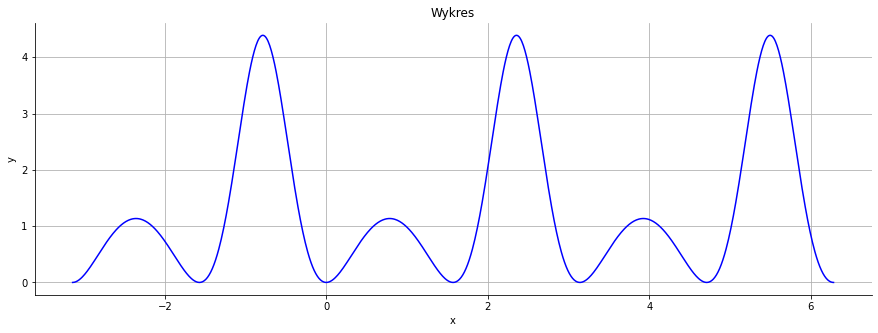

In [28]:
plt.figure(figsize=(15, 5))
plot_fn(g, a, b, step=.01)

## Interpolacja

### $1$. stopnia 
#### (interpolacja liniowa)

In [29]:
def sorted_nodes(xs, ys):
    if len(xs) != len(ys):
        raise ValueError("xs must be the same length as ys")
    n = len(xs)
    xs_ind = sorted(zip(xs, range(n)), key=lambda p: p[0])
    ys_new = [ys[xs_ind[i][1]] for i in range(n)]
    xs_new = [p[0] for p in xs_ind]
    return xs_new, ys_new

def Ψ(x, i, xs):
    if i < 0 or i > len(xs):
        raise ValueError("Wrong i value")
    if i > 0 and xs[i - 1] <= x <= xs[i]:
        return (x - xs[i - 1]) / (xs[i] - xs[i - 1])
    if i < len(xs) and xs[i] < x <= xs[i + 1]:
        return (xs[i + 1] - x) / (xs[i + 1] - xs[i])
    return 0

def binary_search(x, xs):
    l = 0
    r = len(xs) - 1
    
    while l <= r:
        m = (l + r) // 2
        if x > xs[m]:
            l = m + 1
        else:
            r = m - 1
        
    return l

def linear_spline(xs, ys):
    n = len(xs)
    
    def s(x):
        i = binary_search(x, xs)
        y = 0
        if i < n: 
            y += ys[i] * Ψ(x, i, xs)
            if i > 0: y += ys[i - 1] * Ψ(x, i - 1, xs)

        return y
    
    return s

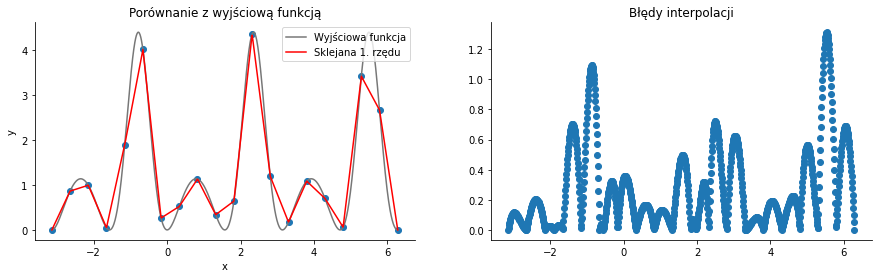

In [30]:
n = 20

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [PlotIntep(linear_spline, 'r', 'Sklejana 1. rzędu')], 
    a, b, n
)

### $2$. stopnia 
#### (interpolacja kwadratowa)

### $3$. stopnia 
#### (interpolacja sześcienna)

In [37]:
from pprint import pprint as pp
import enum
   
class BoundaryConditions(enum.Enum):
    Derivative3rd = 0
    FreeBoundary = 1
    ClampedBoundary = 2

class CubicSpline:
    def __init__(self, xs, ys, *, boundary_condition=BoundaryConditions.Derivative3rd):
        self.n = n = len(ys)
        self.xs = xs
        self.ys = ys
        self.A = np.zeros(3 * n).reshape(n, 3)
        self.B = np.zeros(n)
        self.bc = boundary_condition
        self.fns = []
        self.__solve()
        
    def __call__(self, x):
        i = min(self.search_range_idx(x), self.n - 2)
        return self.fns[i](x)
        
    def h(self, i):
        return self.xs[i + 1] - self.xs[i]
    
    def Δ(self, i):
        return (self.ys[i + 1] - self.ys[i]) / self.h(i)
    
    def search_range_idx(self, x):
        xs = self.xs
        l = 0
        r = self.n - 1

        while l <= r:
            m = (l + r) // 2
            if x >= xs[m]:
                l = m + 1
            else:
                r = m - 1

        return l - 1
    
    def __solve(self):
        h = self.h
        Δ = self.Δ
        
        # The first and the last row will remain empty (filled entirely with zeros)
        for i in range(1, self.n - 1):
            self.A[i, 0] = h(i - 1)
            self.A[i, 1] = 2 * (h(i - 1) + h(i))
            self.A[i, 2] = h(i)
            self.B[i] = Δ(i) - Δ(i - 1)
            
        σs = self.__solve_with_boundary_conditions()
        
        xs = self.xs
        ys = self.ys
        for i in range(self.n - 1):
#             s = lambda i: lambda x: σs[i] / h(i) * (xs[i + 1] - x) ** 3 \
#                                   + σs[i + 1] / h(i) * (x - xs[i]) ** 3 \
#                                   + (ys[i + 1] / h(i) - σs[i + 1] * h(i)) * (x - xs[i]) \
#                                   + (ys[i] / h(i) - σs[i] * h(i)) * (xs[i + 1] - x)
            
            def s(i):
                bi = (ys[i + 1] - ys[i]) / h(i) - h(i) * (σs[i + 1] + 2 * σs[i])
                ci = 3 * σs[i]
                di = (σs[i + 1] - σs[i]) / h(i)
            
                def f(x):
                    diff = x - xs[i]
                    return ys[i] + bi * diff + ci * diff**2 + di * diff**3
                return f
            
            self.fns.append(s(i))
        
    def __solve_with_boundary_conditions(self):
        match self.bc:
            case BoundaryConditions.Derivative3rd:
                return self.__solve_with_derivative_3rd()
            case BoundaryConditions.FreeBoundary:
                return self.__solve_with_free_boundary()
            case BoundaryConditions.ClampedBoundary:
                return self.__solve_with_clamped_boundary()
        
    def __solve_with_derivative_3rd(self):
        start_xs = self.xs[:4]
        start_ys = self.ys[:4]
        end_xs = self.xs[-4:]
        end_ys = self.ys[-4:]
        Δs1 = self.__differential_quotients(start_xs, start_ys)
        Δs2 = self.__differential_quotients(end_xs, end_ys)

        n = self.n
        h = self.h
        Δ = self.Δ
        
        # The first row
        self.A[0, 0] = -h(0)
        self.A[0, 1] = h(0)
        self.B[0] = h(0) ** 2 * Δs1[3]
        
        # The last row
        self.A[n - 1, 0] = h(n - 2)
        self.A[n - 1, 1] = -h(n - 2)
        self.B[n - 1] = -h(n - 2) ** 2 * Δs2[3]
        
        # Use modified Gauss elimination algorithm
        return self.__solve_system_of_equations()
    
    def __solve_with_free_boundary(self):
        return self.__solve_system_of_equations(True)
    
    def solve_with_clamped_boundary(self):
        ...
        
    def __solve_system_of_equations(self):
        A = np.array(self.A, float)
        B = np.array(self.B, float)
        n = len(A)
        X = np.zeros(n, float)
        
        # Elimination
        if A[1, 0] != 0:
            factor = A[0, 0] / A[1, 0]
            A[1] *= factor
            A[1] -= A[0]
            B[1] *= factor
            B[1] -= B[0]
        
        for i in range(2, n):
            if A[i, 0] == 0: continue
            factor = A[i - 1, 1] / A[i, 0]
            A[i] *= factor
            A[i, 0] -= A[i - 1, 1]
            A[i, 1] -= A[i - 1, 2]
            B[i] *= factor
            B[i] -= B[i - 1]
            
        # Back substitution
        X[n - 1] = B[n - 1] / A[n - 1, 1]
        for i in range(n - 2, 0, -1):
            X[i] = (B[i] - A[i, 2] * X[i + 1]) / A[i, 1]
        X[0] = (B[0] - A[0, 1] * X[1]) / A[0, 0]
            
        return X

#     def __solve_system_of_equations(self, drop_first_and_last=False):
#         A = np.array(self.A[1:-1] if drop_first_and_last else self.A, float)
#         B = np.array(self.B[1:-1] if drop_first_and_last else self.B, float)
#         n = len(A)
#         X = np.zeros(n, float)
        
#         # Elimination
#         if drop_first_and_last and A[1, 0] != 0:
#             factor = A[0, 0] / A[1, 0]
#             A[1] *= factor
#             A[1] -= A[0]
#             B[1] *= factor
#             B[1] -= B[0]
        
#         for i in range(2 - drop_first_and_last, n):
#             for j in range(1 + drop_first_and_last):
#                 if A[i, j] == 0: continue
#                 factor = A[i - 1, j + 1] / A[i, 0]
#                 A[i] *= factor
#                 A[i, 0] -= A[i - 1, 1]
#                 A[i, 1] -= A[i - 1, 2]
#                 B[i] *= factor
#                 B[i] -= B[i - 1]
            
#         # Back substitution
#         X[n - 1] = B[n - 1] / A[n - 1, 1]
#         for i in range(n - 2, 0, -1):
#             X[i] = (B[i] - A[i, 2] * X[i + 1]) / A[i, 1]
#         X[0] = (B[0] - A[0, 1] * X[1]) / A[0, 0]
            
#         return X

    @staticmethod
    def __differential_quotients(xs, ys):
        n = len(xs)
        Δs = list(ys)
        
        for j in range(1, n):
            for i in range(n - 1, j - 1, -1):
                Δs[i] = (Δs[i] - Δs[i - 1]) / (xs[i] - xs[i - j])
                
        return Δs

In [38]:
# xs = np.linspace(a, b, 8)
# ys = [g(x) for x in xs]
# CubicSpline(xs, ys, boundary_condition=BoundaryConditions.FreeBoundary)

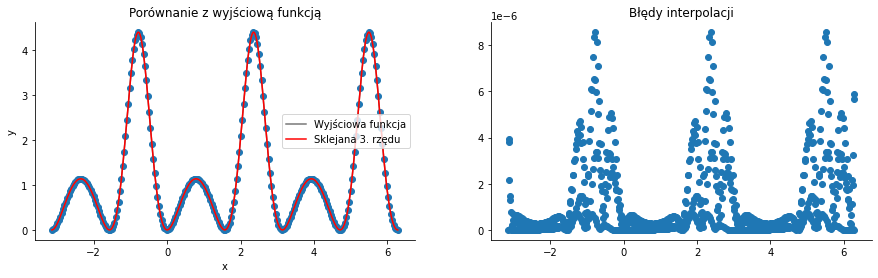

In [39]:
n = 250

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [PlotIntep(CubicSpline, 'r', 'Sklejana 3. rzędu')], 
    a, b, n
)

WOW! Pierwszy raz zaimplementowana przeze mnie metoda interpolacji ma takie same błędy jak ta z biblioteki scipy 😲😲😲

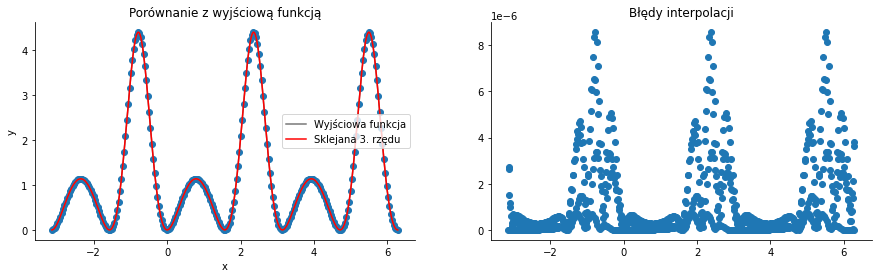

In [40]:
from scipy.interpolate import CubicSpline as CS

n = 250

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [PlotIntep(CS, 'r', 'Sklejana 3. rzędu')], 
    a, b, n
)